# Talking motion signature of individuals

**An attempt to reconstruct the experiment conveyed by Matyas Bohacek**

In [1]:
import numpy as np
import pandas as pd
import logging
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
CORRELATIONS = ""
if "kaggle" in os.getcwd():
    print(f"Running in kaggle...")
    CORRELATIONS = "/kaggle/input/correlations/correlations.csv"
else:
    print(f"Running locally...")
    CORRELATIONS = os.path.join("data", "correlations.csv")

df = pd.read_csv(CORRELATIONS, index_col="clip_name")
print("The dataset was loaded in the dataframe")

# compatibility with the old version of the dataset
if "pristine" in df.columns:
    df.drop("pristine", axis=1, inplace=True)

Running in kaggle...
The dataset was loaded in the dataframe


### Data Exploration and Analysis

#### General information:
The dataset used in this particular implementstion encompasses:
1. **595 minutes** of pristine videos of POI
2. **57 minutes** of videos of 27 celebrities from CelebDF-v2, roughly 2.1 minutes each
3. **12 minutes** of deepfake videos of the POI

#### Temporal information:
- Most of the videos of the POI are taken from 2019 - Q1|2023.
- All of the deepfakes (but one) are based on the videos of the POI from Q3|2023 and onwards

#### Video preprocessing:
- Videos were not preprocessed at all:
    - Some of the fasmes do not contain a person at all
    - Several frames may also contain transitions
- Videos are also separated into small 10s each overlapping by 5 seconds clips

#### Data extraction
- Normalised landmarks, AUs and head rotations are then extracted from the clips
- To represent some complex movements, temporal correlation are extracted for all detected features.

#### Dataset explanation
- The dataset's index conveniently denotes from which video and clip the data was extracted.

**Example:**
`16_id0_fake_clip_8`:
   - `16` number of the video in its group
   - `id0` id of the person in its group
   - `fake` group
   - `clip` *placeholder*, specifies that the data is about a clip, not a video
   - `8` number of the clip in the specific video, the number of which is mentioned in the beginning
    
- Columns of the dataset are correlations bewtween the extracted features. the template is `feature1*feature2`. Total number of correlations: **435**

**Example:**
`leftShoulder_X*rightShoulder_X`

- Total number of clips extracted is **8064**

#### Notes
- The differences from Matyas' dataset are subtle, but they do exist:
    - Videos aren't preprocessed
    - No additional videos of political leaders
    - No mouthV/mouthH features due to the way how the original author used them
    - ...

In [3]:
df.head(5)

,leftShoulder_X*rightShoulder_X,leftShoulder_X*leftElbow_X,leftShoulder_X*rightElbow_X,leftShoulder_X*leftWrist_X,leftShoulder_X*rightWrist_X,leftShoulder_X*leftShoulder_Y,leftShoulder_X*rightShoulder_Y,leftShoulder_X*leftElbow_Y,leftShoulder_X*rightElbow_Y,leftShoulder_X*leftWrist_Y,...,AU23_r*AU25_r,AU23_r*AU26_r,AU23_r*pose_Rx,AU23_r*pose_Rz,AU25_r*AU26_r,AU25_r*pose_Rx,AU25_r*pose_Rz,AU26_r*pose_Rx,AU26_r*pose_Rz,pose_Rx*pose_Rz
clip_name,,,,,,,,,,,,,,,,,,,,,
207_id19_celeb_clip_0,-1.0,0.896910,-0.684285,0.728418,-0.776546,0.914665,0.978394,0.220155,0.290392,0.605656,...,-0.413947,-0.371109,-0.084862,0.256737,0.677971,0.351435,-0.135390,0.078872,-0.074653,-0.656714
214_id20_celeb_clip_2,-1.0,0.944202,-0.994526,0.936670,-0.953693,0.986707,1.000000,0.986293,0.984946,0.997428,...,-0.321518,-0.384210,0.338814,-0.439432,0.674008,-0.113254,0.217822,-0.480208,0.368657,-0.628787
240_id23_celeb_clip_4,-1.0,0.833483,-0.915368,0.702566,-0.928953,0.931838,1.000000,0.953161,0.974447,0.933059,...,-0.567222,0.416525,-0.700947,0.005953,0.163318,0.746491,-0.427656,0.035669,-0.561861,-0.057797
233_id22_celeb_clip_0,-1.0,0.999719,-0.999906,0.264970,-0.999449,0.999979,1.000000,0.999982,0.999413,0.996163,...,-0.412773,-0.273914,0.136155,-0.192124,0.417743,-0.067108,-0.100406,0.315622,0.109584,-0.430541
76_id6_celeb_clip_0,-1.0,0.997736,-0.999290,0.992484,-0.999426,0.997547,1.000000,0.989637,0.999629,0.997910,...,-0.291815,-0.000029,-0.520363,0.042995,0.526085,0.267099,0.143652,0.174757,-0.050362,-0.450811


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8064 entries, 207_id19_celeb_clip_0 to 16_id0_fake_clip_5
Columns: 435 entries, leftShoulder_X*rightShoulder_X to pose_Rx*pose_Rz
dtypes: float64(435)
memory usage: 26.8+ MB


In [5]:
df.describe().map("{:.2f}".format)

,leftShoulder_X*rightShoulder_X,leftShoulder_X*leftElbow_X,leftShoulder_X*rightElbow_X,leftShoulder_X*leftWrist_X,leftShoulder_X*rightWrist_X,leftShoulder_X*leftShoulder_Y,leftShoulder_X*rightShoulder_Y,leftShoulder_X*leftElbow_Y,leftShoulder_X*rightElbow_Y,leftShoulder_X*leftWrist_Y,...,AU23_r*AU25_r,AU23_r*AU26_r,AU23_r*pose_Rx,AU23_r*pose_Rz,AU25_r*AU26_r,AU25_r*pose_Rx,AU25_r*pose_Rz,AU26_r*pose_Rx,AU26_r*pose_Rz,pose_Rx*pose_Rz
count,8055.00,8055.00,8055.00,8055.00,8055.00,8055.00,8055.00,8055.00,8055.00,8055.00,...,7998.00,7998.00,7998.00,7998.00,7998.00,7998.00,7998.00,7998.00,7998.00,8042.00
mean,-1.00,0.93,-0.94,0.69,-0.63,0.50,0.97,0.91,0.94,0.84,...,-0.28,0.04,0.08,-0.05,0.09,-0.03,-0.12,0.19,0.12,-0.04
std,0.00,0.13,0.13,0.39,0.45,0.58,0.15,0.17,0.14,0.26,...,0.22,0.24,0.26,0.28,0.26,0.26,0.27,0.26,0.29,0.41
min,-1.00,-0.62,-1.00,-1.00,-1.00,-1.00,-0.98,-1.00,-1.00,-1.00,...,-0.84,-0.74,-0.90,-0.95,-0.97,-0.98,-0.95,-0.90,-0.92,-1.00
25%,-1.00,0.92,-1.00,0.51,-0.98,0.06,1.00,0.90,0.94,0.77,...,-0.43,-0.13,-0.08,-0.25,-0.09,-0.21,-0.31,0.03,-0.07,-0.33
50%,-1.00,0.98,-0.98,0.88,-0.85,0.80,1.00,0.98,0.99,0.95,...,-0.33,0.02,0.09,-0.06,0.07,-0.04,-0.13,0.20,0.13,-0.05
75%,-1.00,1.00,-0.93,0.98,-0.40,0.99,1.00,1.00,1.00,1.00,...,-0.17,0.18,0.26,0.14,0.24,0.15,0.05,0.37,0.32,0.26
max,-1.00,1.00,0.71,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.86,0.96,0.92,0.94,0.97,0.93,0.96,0.98,0.98,1.00


From the data above, it is obvious that some of the correlations were not calculated correctly due to the imperfections of the dataset.


In [6]:
DATAPOINTS_CNT = len(df)
FEATURES_CNT = len(df.columns)
CELLS_CNT = DATAPOINTS_CNT * FEATURES_CNT
NAN_THRESHOLD_P = 0.07
NAN_THRESHOLD_V = NAN_THRESHOLD_P * FEATURES_CNT

# df.isnull() Return a bitmap for all cells (True/False)
nan_total_ratio = df.isnull().sum().sum() / CELLS_CNT
print(f"Ratio of NaN values to in the dataset: {nan_total_ratio:.2%}")

nan_row_ratio = df.isnull().any(axis=1).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have NaN values in them: {nan_row_ratio:.2%}")

nan_row_ratio = (df.isnull().sum(axis=1) > NAN_THRESHOLD_V).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have more than {NAN_THRESHOLD_P:.2%} NaN values in them: {nan_row_ratio:.2%}, \
[actual NaN features cnt thresh.: {NAN_THRESHOLD_V:.0f}]")

nan_col_ratio = df.isnull().any().sum() / FEATURES_CNT
print(f"Ratio of features which have NaN values in them: {nan_col_ratio:.2%}")

Ratio of NaN values to in the dataset: 3.97%
Ratio of datapoints which have NaN values in them: 39.00%
Ratio of datapoints which have more than 7.00% NaN values in them: 10.94%, [actual NaN features cnt thresh.: 30]
Ratio of features which have NaN values in them: 100.00%


Not surprisingly, **39%** of datapoints have `np.NaN`s in them, and only **11%** of the total number of the datapoints have more than **7%** of their features as `np.NaN`s.

To solve this issue, the following operations will be performed:
- Rows which have more than **7%** of `np.NaN`s in them will be excluded from the dataset.
- Rows which have less than **7%** of `np.NaN`s in them will be refined by changing replacing `np.NaN`s with means.

In [7]:
df = df[df.isna().sum(axis=1) <= NAN_THRESHOLD_V]
print("Datapoints left:", len(df))

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
for column in df.columns:
    df[column] = imputer.fit_transform(df[[column]])
    
print(f"Control - number of NaNs in the dataset:", df.isnull().sum().sum())

Datapoints left: 7182
Control - number of NaNs in the dataset: 0


To further control how certain features describe the identity lets split the dataset into 3:
- All feature combined
- Only facial
- Only body

In [8]:
df_full = df

body_columns = [col for col in df.columns if col.endswith('_X') or col.endswith('_Y')]
df_body = df[body_columns]

face_columns = [col for col in df.columns if not (col.endswith('_X') or col.endswith('_Y'))]
df_face = df[face_columns]

Add the `y` pd.Series which would represent the target variable

In [9]:
y = pd.Series(df.index.str.contains("pristine"))

Although all of the features are Pearson correlations, still, they can be standardized to avoid potential probllems because distribution of each feature is unknown at this point. (Irrational to check each one)

In [10]:
scaler = StandardScaler()

X_full = scaler.fit_transform(df_full)
X_body = scaler.fit_transform(df_body)
X_face = scaler.fit_transform(df_face)

#### Model training

In [11]:
def base_model(X: np.ndarray):
    param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)

    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train, y_train)

    y_pred = best_svm.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Train the first full model to have a baseline

In [12]:
base_model(X_full)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9665796344647519
[[ 136   30]
 [  13 1258]]
              precision    recall  f1-score   support

       False       0.91      0.82      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.94      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



Now the body-only

In [13]:
base_model(X_body)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9096605744125327
[[  41  125]
 [  12 1259]]
              precision    recall  f1-score   support

       False       0.77      0.25      0.37       166
        True       0.91      0.99      0.95      1271

    accuracy                           0.90      1437
   macro avg       0.84      0.62      0.66      1437
weighted avg       0.89      0.90      0.88      1437



And the face-only

In [14]:
base_model(X_face)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9658833768494344
[[ 134   32]
 [  11 1260]]
              precision    recall  f1-score   support

       False       0.92      0.81      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.95      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



Run the full model for 10 times to get its average performance

In [15]:
f1 = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train, y_train)
    
    f1.append(best_svm.predict(X_test))
    
print("Average f1 through 10 random splits: ", sum(f1)/len(f1))

#### Simple visualization

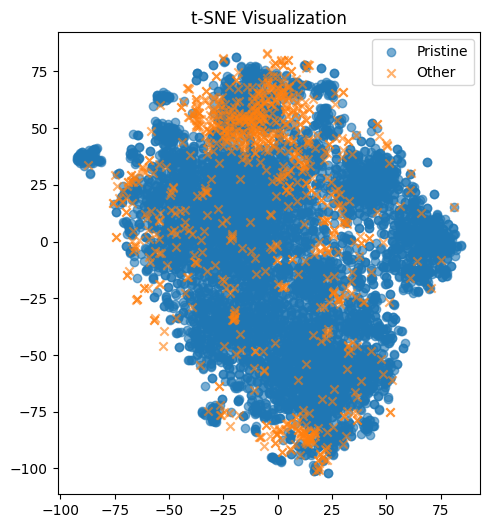

In [17]:
# Adjust PCA components
pca = PCA(n_components=50)  # Increased to 50 components
X_pca = pca.fit_transform(X_full)

tsne = TSNE(
    n_components=2,
    n_iter=3000,          # Increased iterations
    perplexity=40,        # Adjusted perplexity
    learning_rate=200,    # Adjusted learning rate
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca)

# Plotting the t-SNE results
plt.figure(figsize=(12, 6))

# t-SNE subplot
plt.subplot(1, 2, 1)
plt.scatter(
    X_tsne[y == 1, 0],
    X_tsne[y == 1, 1],
    label="Pristine",
    alpha=0.6,
    marker='o'
)
plt.scatter(
    X_tsne[y == 0, 0],
    X_tsne[y == 0, 1],
    label="Other",
    alpha=0.6,
    marker='x'
)
plt.title('t-SNE Visualization')
plt.legend()
plt.show()